# Mod 2 Project - Hypothesis Testing

First we start by loading the libraries we'll need for this project

In [79]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import sqlalchemy
from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import Session, sessionmaker

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from scipy.stats import ttest_1samp, ttest_ind
from scipy.stats import levene, shapiro, mannwhitneyu, kruskal



# Connect to Database

Create a session to the Northwind sqlite database

In [3]:
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

Obtaining table names of database and table information

In [4]:
inspector = inspect(engine)
print(inspector.get_table_names())

2019-07-22 12:44:54,010 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-07-22 12:44:54,011 INFO sqlalchemy.engine.base.Engine ()
2019-07-22 12:44:54,012 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-07-22 12:44:54,013 INFO sqlalchemy.engine.base.Engine ()
2019-07-22 12:44:54,015 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-07-22 12:44:54,015 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In order to understand the Column Names better, we can use a function that will print the column name and the type of information stored in each column. This helps us to see what is listed in each table of our data. The next few lines are exploratory into the database to see how everything compares to the EDA, what information to use, and what information won't be useful. 

In [5]:
# Function to print out the names of the columns
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))


In [6]:
#Try Function on Order
get_columns_info('Order')

2019-07-22 12:44:56,091 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-07-22 12:44:56,092 INFO sqlalchemy.engine.base.Engine ()
Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: INTEGER
Name: OrderDate 	 Type: VARCHAR(8000)
Name: RequiredDate 	 Type: VARCHAR(8000)
Name: ShippedDate 	 Type: VARCHAR(8000)
Name: ShipVia 	 Type: INTEGER
Name: Freight 	 Type: DECIMAL
Name: ShipName 	 Type: VARCHAR(8000)
Name: ShipAddress 	 Type: VARCHAR(8000)
Name: ShipCity 	 Type: VARCHAR(8000)
Name: ShipRegion 	 Type: VARCHAR(8000)
Name: ShipPostalCode 	 Type: VARCHAR(8000)
Name: ShipCountry 	 Type: VARCHAR(8000)


Cool, looks like the function is working. We can use this to explore some of the data to see how well it matches to what we expect. Let's look at these a little further to get an idea of our data

In [7]:
# Checking the Other Tables
print(get_columns_info('Product'))
print(get_columns_info('OrderDetail'))
print(get_columns_info('Order'))

2019-07-22 12:44:57,192 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")
2019-07-22 12:44:57,193 INFO sqlalchemy.engine.base.Engine ()
Table Name: Product

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER
None
2019-07-22 12:44:57,196 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-07-22 12:44:57,197 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT
None
Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: 

In [8]:
#Create a connection to engine
con = engine.connect()

In [9]:
# Practice Query and store into dataframe
q = '''SELECT * FROM [Order]''' #simple query
df_order = pd.read_sql_query(q, engine)
df_order.head()

2019-07-22 12:44:58,110 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-07-22 12:44:58,111 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


# Hypothesis 1: Discounts

The first hypothesis we tested was to see if discounts had an effect on the quantity of items in an order, i.e. do discounts cause customers to have larger than normal orders? 

In order to test this, we pulled all information from the OrderDetail Table, which contains the order ID, the product ID, and the discount. 

In [10]:
# Query the OrderDetail table for the orderID, product ID, and discount. 
q = '''SELECT OrderID, ProductID, Discount FROM OrderDetail'''

#Load the query into a database, and display the first 15 lines of the dataframe
df_h1 = pd.read_sql_query(q, engine)
df_h1.head(15)

2019-07-22 12:44:58,960 INFO sqlalchemy.engine.base.Engine SELECT OrderID, ProductID, Discount FROM OrderDetail
2019-07-22 12:44:58,961 INFO sqlalchemy.engine.base.Engine ()


,OrderId,ProductId,Discount
0,10248,11,0.00
1,10248,42,0.00
2,10248,72,0.00
3,10249,14,0.00
4,10249,51,0.00
5,10250,41,0.00
6,10250,51,0.15
7,10250,65,0.15
8,10251,22,0.05
9,10251,57,0.05


Since there are multiple discounts across orders, it would be best to see the types of discounts we have, and determine if we should group them by order level or not

In [11]:
df_h1.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

It seems like we have multiple discounts, some of which seem oddly small (.01, .02, .03, etc.) so it would make more sense to have one discount level per order, grouped by the order ID, and using the maximum discount given on that order

In [12]:
# Create a list of the unique order IDs and check the length
order_nums = df_h1.OrderId.unique()
len(order_nums)

830

I will use a dictionary to resolve this. The key value pair will be the unique order id, with values being how many repeats of that orderID exist (in order to get the quantity of items in the order), and the maximum discount given at that orderID. 

In [13]:
# Create an empty dictionary and use a for loop to fill in key value pairs
dc = {}
for num in order_nums:
    k = num
    val = [len(df_h1[df_h1.OrderId == num]), df_h1.Discount[df_h1.OrderId == num].max()]
    dc[k] = val

In [14]:
# Create dataframe from dictionary and display the first values to get an
# idea of the shape
df_orders = pd.DataFrame.from_dict(dc, orient = 'index')
df_orders.head()

,0,1
10248,3,0.00
10249,2,0.00
10250,3,0.15
10251,3,0.05
10252,3,0.05


Great. Now that we have the new dataframe, we should check the length of it to make sure everything was filled and that it matches the length of the unique order id's list we saw before. If it matches, we can then make it cleaner by renaming the coluns, and adding an index to the dataframe. 

In [15]:
# Check length
len(df_orders) == len(order_nums)

True

In [16]:
# Rename Columns and add index. Display the dataframe to check
df_orders.reset_index(inplace = True)
df_orders.columns = ['id', 'quantity', 'discount']
df_orders.head()

,id,quantity,discount
0,10248,3,0.00
1,10249,2,0.00
2,10250,3,0.15
3,10251,3,0.05
4,10252,3,0.05


I want to look more into the value counts of the discounts to see how frequently discounts are applied

In [17]:
# Explore Value counts and shape of data
df_orders.discount.value_counts()

0.00    450
0.05     86
0.15     75
0.10     74
0.20     73
0.25     72
Name: discount, dtype: int64

Since there are so many orders without a discount, there is opportunity here to classify orders on if they have a discount or not, and create a boolean variable based on this information. Let's write a function that would do this for us

In [18]:
# Function that returns 1 if an order has a discount, and 0 if it does not
def has_discount (row):
    if row['discount'] > 0:
        return 1
    return 0

In [19]:
# Apply this to the dataframe on the row leve (axis = 1)
df_orders.apply (lambda row: has_discount(row), axis=1)

0      0
1      0
2      1
3      1
4      1
5      0
6      1
7      0
8      0
9      0
10     1
11     0
12     1
13     0
14     1
15     1
16     1
17     0
18     1
19     1
20     0
21     1
22     0
23     0
24     0
25     1
26     0
27     1
28     0
29     0
      ..
800    0
801    1
802    1
803    1
804    1
805    1
806    0
807    0
808    0
809    0
810    0
811    0
812    0
813    0
814    1
815    1
816    1
817    1
818    0
819    0
820    1
821    0
822    1
823    1
824    0
825    0
826    1
827    1
828    1
829    1
Length: 830, dtype: int64

Since this all looks correct, let's add a new column to the dataframe that contains all the above information

In [20]:
df_orders['has_discount'] = df_orders.apply (lambda row: has_discount(row), axis=1)

In [21]:
df_orders.head()

,id,quantity,discount,has_discount
0,10248,3,0.00,0
1,10249,2,0.00,0
2,10250,3,0.15,1
3,10251,3,0.05,1
4,10252,3,0.05,1


Great! We can now start looking at the discount hypothesis from two levels: if the order contains a discount or not affects the number of items in the order, and if the level of discount affects the number of items in the order. Let's start with the first analysis by visualizing the data, and then running a t-test between the two categories. 

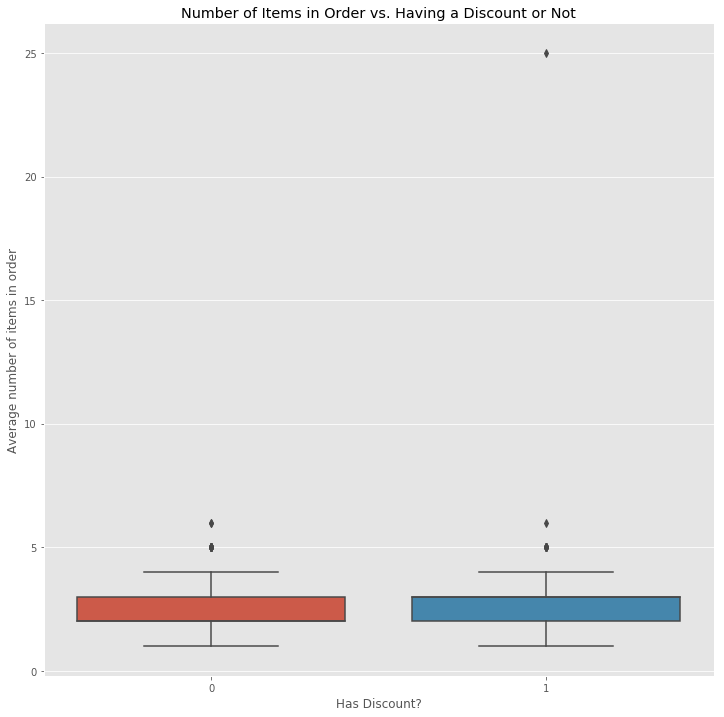

In [22]:
# Visualize Boolean Discount Data
plt.figure(figsize=(12,12))
sns.boxplot(y='quantity',x='has_discount', data=df_orders)
plt.title('Number of Items in Order vs. Having a Discount or Not')
plt.xlabel('Has Discount?')
plt.ylabel('Average number of items in order');


It looks like we have a large outlier. Let's remove it from the dataset and revisualze the data. 

In [23]:
# Find outlier in where the order has a discount, and remove it based on 
# index of that datapoint 
highest = df_orders.quantity[df_orders.has_discount == 1].max()
dex = df_orders[df_orders.quantity == highest].index
df_orders.drop(index = dex, inplace = True)

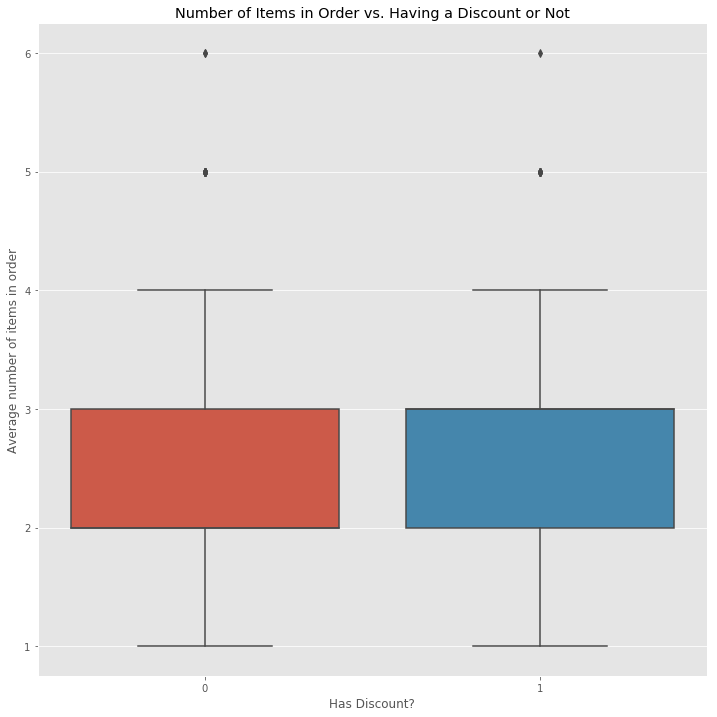

In [24]:
# Visualize Boolean Discount Data
plt.figure(figsize=(12,12))
sns.boxplot(y='quantity',x='has_discount', data=df_orders)
plt.title('Number of Items in Order vs. Having a Discount or Not')
plt.xlabel('Has Discount?')
plt.ylabel('Average number of items in order');



Cool, looks much better. Let's run a T-Test on the two discounts to see if there is a significant difference between the two. We define our hypotheses as:

**Null Hypothesis**: Having a discount has no significant effect on the number of items in the order

**Alternate Hypothesis**: Having a discount significantly changes the number of items in an order 

In [25]:
# T Test
yes = df_orders.quantity[df_orders.has_discount == 1]
no = df_orders.quantity[df_orders.has_discount == 0]
ttest_ind(yes, no)

Ttest_indResult(statistic=3.0046828208473766, pvalue=0.0027388234015249566)

In [26]:
# Mann Whitney Test to double check because of non-normality of data
mannwhitneyu(yes,no)

MannwhitneyuResult(statistic=74129.0, pvalue=0.00037140794471339207)

According to both tests, we can reject the null hypothesis at alpha level .05. I want to look a little further into this to see if there was a significant effect of the individual level of discount on the number of items in the order. First I will visualize the data at each discount level, and then I will use an ANOVA test across the different discount levels

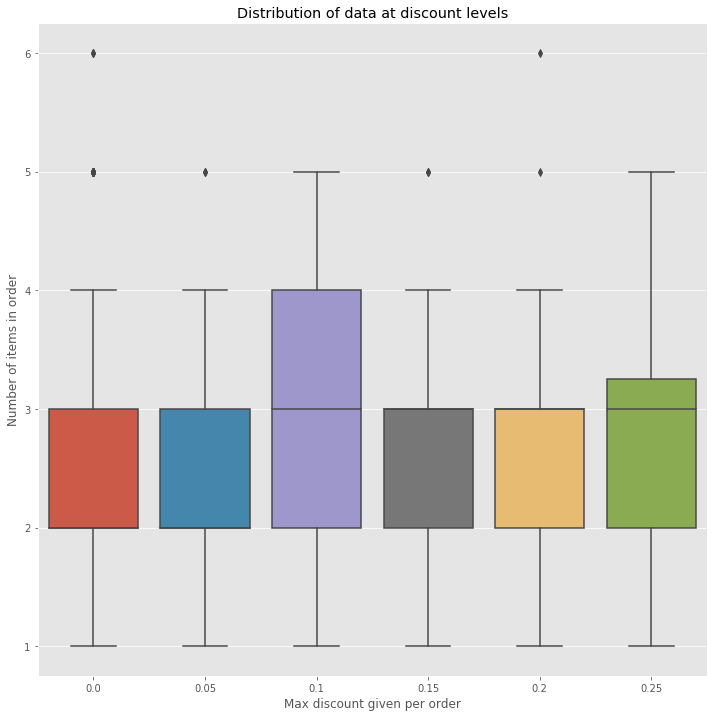

In [27]:
# Visualize again to check
plt.figure(figsize=(12,12))
sns.boxplot(y='quantity',x='discount', data=df_orders)
plt.title('Distribution of data at discount levels')
plt.xlabel('Max discount given per order')
plt.ylabel('Number of items in order');

We can define our hypotheses as follows:

**Null Hypothesis:** discounts have no affect on the number of products ordered by customers

**Alternate Hypothesis:** discounts have a signficant affect at alpha = .05 on the number of products ordered by customers

In [28]:
# Use ANOVA Test since this is multicomparison
results = ols('quantity ~ C(discount)', data=df_orders).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               quantity   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.012
Date:                Mon, 22 Jul 2019   Prob (F-statistic):             0.0106
Time:                        12:46:03   Log-Likelihood:                -1230.1
No. Observations:                 829   AIC:                             2472.
Df Residuals:                     823   BIC:                             2501.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.4667      0.050     48.858      0.000       2.368       2.566
C(discount)[T.0.05]     0.0217      0.126      0.172      0.863      -0.226       0.269
C(discount)[T.0.1]      0.4252      0.134      3.165      0.002       0.162       0.689
C(discount)[T.0.15]     0.2400      0.134      1.797      0.073      -0.022       0.502
C(discount)[T.0.2]      0.1861      0.136      1.369      0.171      -0.081       0.453
C(discount)[T.0.25]     0.2833      0.136      2.084      0.037       0.017       0.550
==============================================================================
Omnibus:                       25.511   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.512
Skew:                           0.418   Prob(JB):                     1.75e-06
Kurtosis:                       2.737   Cond. No.                         4.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the P Value of the F statistic is less than our alpha level, we can reject the null hypothesis. The largest effect is seen at the highest T levels with smallest p values (those less that .05), so discount levels of .1 and .25 have the largest effect on the number of items in the order

# Hypothesis 2: Regionality of Customers

Next I want to look into if the of where customers are from have an effect on the average order size in an order, i.e. are certain regions ordering larger orders than others. In order to do this, I will have to connect the OrderId table with the order table with the customer table. 

In [29]:
# Query to join OrderID, Order, and Customer table
q = '''SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, c.Region as region \
FROM OrderDetail od \
LEFT JOIN [Order] o ON od.OrderId = o.Id \
LEFT JOIN Customer c ON o.CustomerId = c.Id \
GROUP BY od.OrderId'''

df_ter = pd.read_sql_query(q, engine) #puts the information from the query into a dataframe


2019-07-22 12:49:36,677 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, c.Region as region FROM OrderDetail od LEFT JOIN [Order] o ON od.OrderId = o.Id LEFT JOIN Customer c ON o.CustomerId = c.Id GROUP BY od.OrderId
2019-07-22 12:49:36,678 INFO sqlalchemy.engine.base.Engine ()


In [30]:
df_ter.head(15)

,OrderId,total_bookings,region
0,10248,440.0,Western Europe
1,10249,1863.4,Western Europe
2,10250,1813.0,South America
3,10251,670.8,Western Europe
4,10252,3730.0,Western Europe
5,10253,1444.8,South America
6,10254,625.2,Western Europe
7,10255,2490.5,Western Europe
8,10256,517.8,South America
9,10257,1119.9,South America


Next I want to explore the data a little bit to see how many unique regions there are, if there are any NA's (can we drop them if necessary), and to visualize the data a bit. 

In [31]:
# How many unique regions
len(df_ter.region.unique())

10

In [32]:
# length of the dataframe
len(df_ter)

830

In [82]:
# check for any NAs
sum(df_ter.region.isna())

29

In [33]:
# Since there are only 29/830 NAs, drop NA Region Values
df_ter = df_ter.dropna()

In [37]:
df_ter.region.value_counts()

Western Europe     272
North America      152
South America      127
British Isles       75
Southern Europe     64
Northern Europe     55
Scandinavia         28
Central America     21
Eastern Europe       7
Name: region, dtype: int64

Since there are a few regions (Eastern Europe, Central America, and Scandinavia) where there is not enough data to pull accurate conclusions (n < 30). Let's disclude them from our analysis. 

In [108]:
regions = ['Western Europe', 'North America', 'South America', 'British Isles', 'Southern Europe', 'Northern Europe']
df_ter2 = df_ter[df_ter.region.isin(regions)]

In [109]:
df_ter2.head()

,OrderId,total_bookings,region
0,10248,440.0,Western Europe
1,10249,1863.4,Western Europe
2,10250,1813.0,South America
3,10251,670.8,Western Europe
4,10252,3730.0,Western Europe


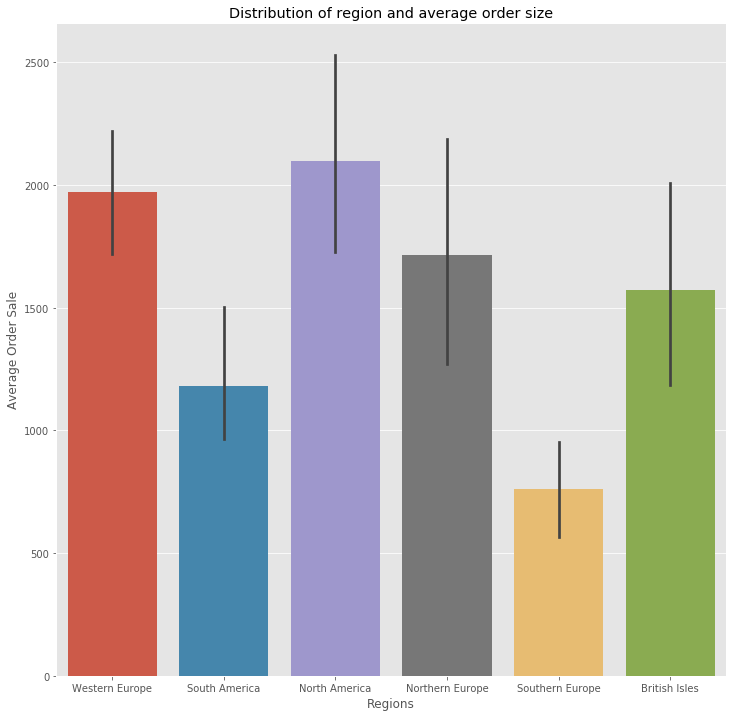

In [111]:
# Visialize the data
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='region', data=df_ter2)
plt.title('Distribution of region and average order size')
plt.xlabel('Regions')
plt.ylabel('Average Order Sale');

Based off the visualization, there are some countries that look to have much higher than average order sales than others. Since we are comparing multiple means, let's use an ANOVA test to test this. We define our hypotheses as follows:

**Null Hypothesis**: Customer Region has no effect on the average order size

**Alternate Hypothesis**: Customer Region has an effect on the average order size at an alpha level of .05

In [112]:
results = ols('total_bookings ~ C(region)', data=df_ter2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     6.832
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           3.05e-06
Time:                        15:07:32   Log-Likelihood:                -6714.6
No. Observations:                 745   AIC:                         1.344e+04
Df Residuals:                     739   BIC:                         1.347e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     1572.4520    230.276      6.829      0.000    1120.379    2024.525
C(region)[T.North America]     525.5814    281.410      1.868      0.062     -26.877    1078.040
C(region)[T.Northern Europe]   142.2016    354.029      0.402      0.688    -552.821     837.224
C(region)[T.South America]    -389.6475    290.417     -1.342      0.180    -959.788     180.493
C(region)[T.Southern Europe]  -812.9881    339.364     -2.396      0.017   -1479.220    -146.756
C(region)[T.Western Europe]    398.4105    260.093      1.532      0.126    -112.199     909.020
==============================================================================
Omnibus:                      566.090   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9668.678
Skew:                           3.336   Prob(JB):                         0.00
Kurtosis:                      19.339   Cond. No.                         9.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regions have a significant effect on the average order size with a p value of .002. Let's look deeper to see which regions have the largest effect by using a tukey HSD test. 

In [113]:
mc = MultiComparison(df_ter2.total_bookings, df_ter2.region)
mc_results = mc.tukeyhsd()
print(mc_results)

          Multiple Comparison of Means - Tukey HSD,FWER=0.05          
     group1          group2      meandiff    lower      upper   reject
----------------------------------------------------------------------
 British Isles   North America   525.5814  -278.4591   1329.622 False 
 British Isles  Northern Europe  142.2016  -869.3246  1153.7279 False 
 British Isles   South America  -389.6475  -1219.4231  440.128  False 
 British Isles  Southern Europe -812.9881  -1782.614   156.6378 False 
 British Isles   Western Europe  398.4105  -344.7234  1141.5444 False 
 North America  Northern Europe -383.3798  -1279.9813  513.2217 False 
 North America   South America  -915.2289  -1600.2373 -230.2205  True 
 North America  Southern Europe -1338.5695 -2187.6181 -489.5209  True 
 North America   Western Europe -127.1709  -704.1953   449.8534 False 
Northern Europe  South America  -531.8491  -1451.5994  387.9011 False 
Northern Europe Southern Europe -955.1897  -2002.8479  92.4684  False 
Northe

We can reject the null at the pairings of North America and South Amerca, North America and Southern Europe, Southern Europe and Western Europe, and South America and Western Europe. This is showing that there is significance between the lowest on average sales price (Southern Europe and South America), and the two largest (North America and Western Europe). 



# Hypothesis 3: Regionality of Suppliers 

Do suppliers have an effect on the number of orders that go out?
Are some suppliers generating more revenue than others?

In [48]:
# Link Supplier Company Name by the supploer id to the product id to the 
#order details (unit price x quantity)

q = '''SELECT od.OrderId, od.ProductId, SUM(od.UnitPrice*od.Quantity) , s.CompanyName, s.Country \
FROM OrderDetail od \
LEFT JOIN [Product] p ON od.ProductId = p.Id \
LEFT JOIN Supplier s ON p.SupplierId = s.Id \
GROUP BY od.OrderId'''

df_s = pd.read_sql_query(q, engine)


2019-07-22 13:44:26,609 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, od.ProductId, SUM(od.UnitPrice*od.Quantity) , s.CompanyName, s.Country FROM OrderDetail od LEFT JOIN [Product] p ON od.ProductId = p.Id LEFT JOIN Supplier s ON p.SupplierId = s.Id GROUP BY od.OrderId
2019-07-22 13:44:26,610 INFO sqlalchemy.engine.base.Engine ()


In [49]:
df_s.head()

,OrderId,ProductId,SUM(od.UnitPrice*od.Quantity),CompanyName,Country
0,10248,11,440.0,Cooperativa de Quesos 'Las Cabras',Spain
1,10249,14,1863.4,Mayumi's,Japan
2,10250,41,1813.0,New England Seafood Cannery,USA
3,10251,22,670.8,PB Knäckebröd AB,Sweden
4,10252,20,3730.0,"Specialty Biscuits, Ltd.",UK


In [50]:
len(df_s)

830

In [80]:
# Rename Column Headers and display the new dataframe
df_s.columns = ['OrderId', 'ProductId', 'total_bookings', 'company_name', 'country']

In [81]:
df_s.head()

,OrderId,ProductId,total_bookings,company_name,country
0,10248,11,440.0,Cooperativa de Quesos 'Las Cabras',Spain
1,10249,14,1863.4,Mayumi's,Japan
2,10250,41,1813.0,New England Seafood Cannery,USA
3,10251,22,670.8,PB Knäckebröd AB,Sweden
4,10252,20,3730.0,"Specialty Biscuits, Ltd.",UK


In [53]:
# Check for value counts
df_s.country.value_counts()

UK             157
USA            120
Australia      103
Germany         87
Japan           84
Italy           46
Spain           44
France          39
Sweden          31
Brazil          28
Canada          25
Norway          23
Singapore       14
Denmark         12
Finland          9
Netherlands      8
Name: country, dtype: int64

Once again, we are seeing there are a few countries that do not have enough data (n < 30) to be considered in the analysis. Let's create a new dataframe with only countries that have enough data. 

In [82]:
# Create a list of countries with enough data and use a new dataframe with just that information
countries = ['UK', 'USA', 'Australia', 'Germany', 'Japan', 'Italy', 'Spain', 'France', 'Sweden']
df_s2 = df_s[df_s.country.isin(countries)]

In [83]:
# Check to see if worked
df_s2.country.value_counts()

UK           157
USA          120
Australia    103
Germany       87
Japan         84
Italy         46
Spain         44
France        39
Sweden        31
Name: country, dtype: int64

Great - Let's Visualize the data, and then run an ANOVA Test to see if there is any significance. 

**Null Hypothesis**: There is no effect of Supplier Country on the average order size

**Alternatite Hypothesis**: There is a signficant effect of supplier country on the average order size at an alpha level of .05

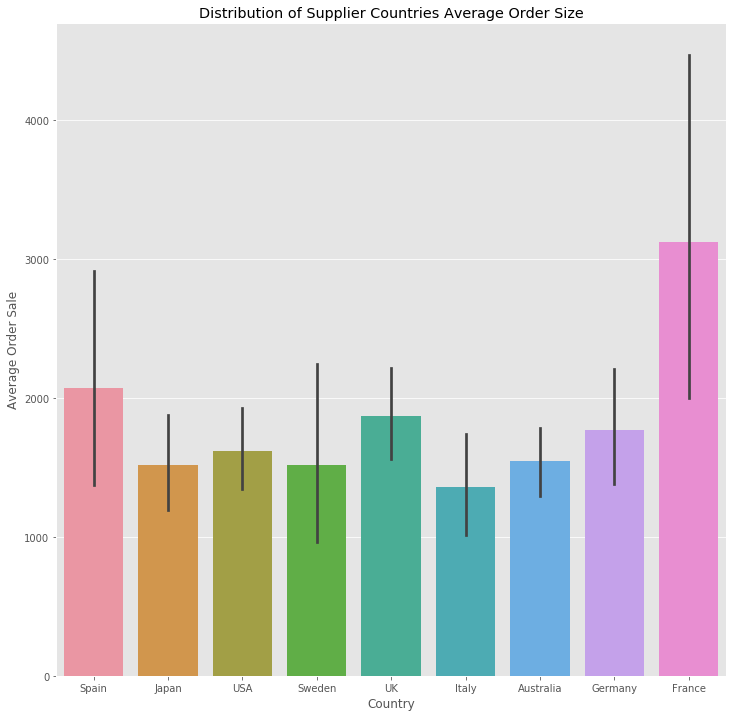

In [69]:
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='country', data=df_s2)
plt.title('Distribution of Supplier Countries Average Order Size')
plt.xlabel('Country')
plt.ylabel('Average Order Sale');

In [59]:
# Anova Test
results = ols('total_bookings ~ C(country)', data=df_s2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.921
Date:                Mon, 22 Jul 2019   Prob (F-statistic):            0.00325
Time:                        13:46:11   Log-Likelihood:                -6431.8
No. Observations:                 711   AIC:                         1.288e+04
Df Residuals:                     702   BIC:                         1.292e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1543.0283    203.621      7.578      0.000    1143.250    1942.807
C(country)[T.France]   1579.6896    388.539      4.066      0.000     816.853    2342.526
C(country)[T.Germany]   224.9253    300.912      0.747      0.455    -365.870     815.720
C(country)[T.Italy]    -187.4262    366.468     -0.511      0.609    -906.931     532.079
C(country)[T.Japan]     -23.8944    303.811     -0.079      0.937    -620.381     572.592
C(country)[T.Spain]     525.5371    372.181      1.412      0.158    -205.185    1256.259
C(country)[T.Sweden]    -25.0300    423.344     -0.059      0.953    -856.203     806.143
C(country)[T.UK]        323.2290    262.035      1.234      0.218    -191.237     837.695
C(country)[T.USA]        76.7438    277.577      0.276      0.782    -468.237     621.725
==============================================================================
Omnibus:                      493.770   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6153.482
Skew:                           3.045   Prob(JB):                         0.00
Kurtosis:                      16.062   Cond. No.                         9.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We're seeing significance with a p value of .003. The largest T value occurs at France with the only significant p value. Let's run a Tukey Test to see which pairings specifically are more significant than others

In [63]:
# Tukey HSD Test
mc = MultiComparison(df_s2.total_bookings, df_s2.country)
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
  group1   group2  meandiff    lower      upper   reject
--------------------------------------------------------
Australia  France 1579.6896   370.7614  2788.6178  True 
Australia Germany  224.9253  -711.3548  1161.2055 False 
Australia  Italy  -187.4262  -1327.6835  952.8311 False 
Australia  Japan   -23.8944  -969.1947   921.4059 False 
Australia  Spain   525.5371   -632.496  1683.5702 False 
Australia  Sweden   -25.03   -1342.2557 1292.1957 False 
Australia    UK    323.229   -492.0861  1138.5441 False 
Australia   USA    76.7438   -786.9314   940.419  False 
  France  Germany -1354.7643 -2593.8478 -115.6807  True 
  France   Italy  -1767.1158 -3166.7208 -367.5107  True 
  France   Japan  -1603.584  -2849.4974 -357.6706  True 
  France   Spain  -1054.1525 -2468.277   359.972  False 
  France   Sweden -1604.7196 -3151.9077  -57.5314  True 
  France     UK   -1256.4606 -2406.8719 -106.0492  True 
  France    USA   -1502.9458 -2

From here we can infer that France between every country except for Germany, has the largest effect on average order size. There are no other pairings of countries that have an effect, which confirms what we saw in the graph that France has the largest order size of any country on the supplier side.

We can explore this a little further by looking at the individual supplier companies to see if there's any effect on the order size there. Let's check to make sure the value counts are usable, and then visualize the data. 

In [64]:
df_s.company_name.value_counts()

Exotic Liquids                            90
Pavlova, Ltd.                             81
Specialty Biscuits, Ltd.                  67
Mayumi's                                  50
Cooperativa de Quesos 'Las Cabras'        44
Grandma Kelly's Homestead                 41
Plutzer Lebensmittelgroßmärkte AG         39
Tokyo Traders                             34
Formaggi Fortini s.r.l.                   33
Heli Süßwaren GmbH & Co. KG               31
New Orleans Cajun Delights                30
New England Seafood Cannery               29
Refrescos Americanas LTDA                 28
Norske Meierier                           23
G'day, Mate                               22
Bigfoot Breweries                         20
Aux joyeux ecclésiastiques                18
Gai pâturage                              17
Nord-Ost-Fisch Handelsgesellschaft mbH    17
PB Knäckebröd AB                          16
Ma Maison                                 16
Svensk Sjöföda AB                         15
Leka Tradi

There seem to be quite a few companies that don't have enough data to be considered. Let's only use ones with data above or equal to 30. 

In [84]:
# Only select data with companies with data larger than 30
companies = ['Exotic Liquids', 'Pavlova, Ltd.', 'Specialty Biscuits, Ltd.', "Mayumi's", 
            "Cooperativa de Quesos 'Las Cabras'", "Grandma Kelly's Homestead", 
            "Plutzer Lebensmittelgroßmärkte AG", "Tokyo Traders", "Formaggi Fortini s.r.l.",
            "Heli Süßwaren GmbH & Co. KG", "New Orleans Cajun Delights"]
df_s3 = df_s[df_s.company_name.isin(companies)]

In [85]:
# check to see if worked
df_s3.company_name.value_counts()

Exotic Liquids                        90
Pavlova, Ltd.                         81
Specialty Biscuits, Ltd.              67
Mayumi's                              50
Cooperativa de Quesos 'Las Cabras'    44
Grandma Kelly's Homestead             41
Plutzer Lebensmittelgroßmärkte AG     39
Tokyo Traders                         34
Formaggi Fortini s.r.l.               33
Heli Süßwaren GmbH & Co. KG           31
New Orleans Cajun Delights            30
Name: company_name, dtype: int64

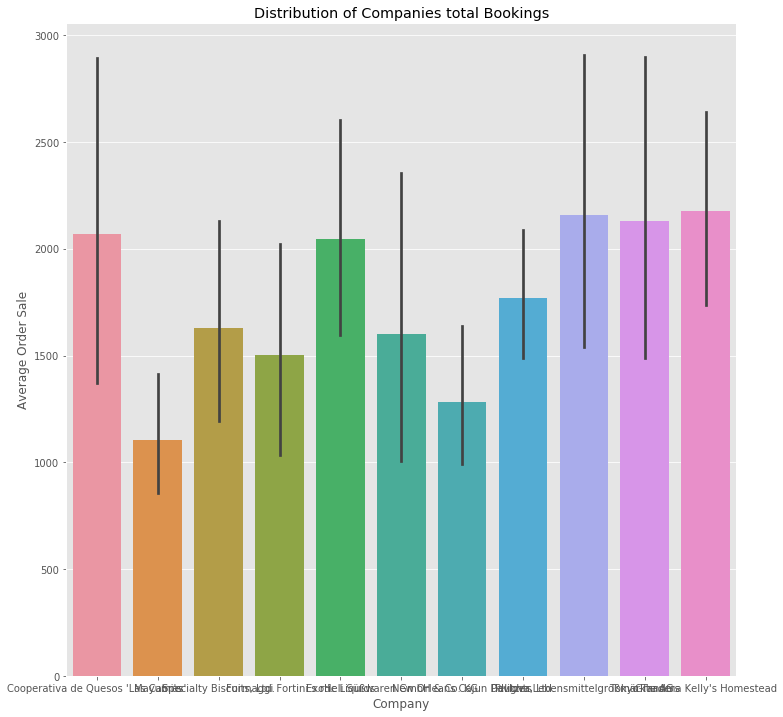

In [75]:
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='company_name', data=df_s3)
plt.title('Distribution of Companies total Bookings')
plt.xlabel('Company')
plt.ylabel('Average Order Sale');

Based off the SE bars, it doesn't look like there will be much significance, but let's run an ANOVA to test anyway:

**Null Hypothesis**: Supplier Companies have no effect on the average order sales size

**Alternative Hypothesis**: Supplier companies have a significant effect on the average order sales size

In [86]:
# Anova Test
results = ols('total_bookings ~ C(company_name)', data=df_s3).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.663
Date:                Mon, 22 Jul 2019   Prob (F-statistic):             0.0864
Time:                        14:14:30   Log-Likelihood:                -4843.5
No. Observations:                 540   AIC:                             9709.
Df Residuals:                     529   BIC:                             9756.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                             2068.5655    289.668      7.141      0.000    1499.524    2637.607
C(company_name)[T.Exotic Liquids]                      -25.0181    353.453     -0.071      0.944    -719.363     669.327
C(company_name)[T.Formaggi Fortini s.r.l.]            -566.5291    442.476     -1.280      0.201   -1435.754     302.696
C(company_name)[T.Grandma Kelly's Homestead]           106.1909    417.079      0.255      0.799    -713.144     925.526
C(company_name)[T.Heli Süßwaren GmbH & Co. KG]        -469.2309    450.558     -1.041      0.298   -1354.334     415.872
C(company_name)[T.Mayumi's]                           -964.0395    397.173     -2.427      0.016   -1744.270    -183.809
C(company_name)[T.New Orleans Cajun Delights]         -785.9455    454.942     -1.728      0.085   -1679.661     107.770
C(company_name)[T.Pavlova, Ltd.]                      -299.6418    359.843     -0.833      0.405   -1006.539     407.256
C(company_name)[T.Plutzer Lebensmittelgroßmärkte AG]    91.3658    422.579      0.216      0.829    -738.773     921.505
C(company_name)[T.Specialty Biscuits, Ltd.]           -440.4587    372.842     -1.181      0.238   -1172.892     291.974
C(company_name)[T.Tokyo Traders]                        60.2860    438.742      0.137      0.891    -801.604     922.176
==============================================================================
Omnibus:                      367.947   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4249.900
Skew:                           2.917   Prob(JB):                         0.00
Kurtosis:                      15.444   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As seen from the graph, there is no significant effect of supplier companies on average order size. We do not reject the null

# Hypothesis 4: Seasonality  

Lastly, I want to explore if there is any effect of the time of sale on the average order size. This requires linking the OrderID table and the Order table in order to get the total bookings for each order and the order date of each order. 

In [89]:
# Query for orderid, total bookings, and order date. Connect Order Detail and Order Tables by the OrderId
q = '''SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, o.OrderDate as date \
FROM OrderDetail od \
LEFT JOIN [Order] o ON od.OrderId = o.Id \
GROUP BY od.OrderId'''
df_seasons = pd.read_sql_query(q, engine)


2019-07-22 14:21:03,190 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, o.OrderDate as date FROM OrderDetail od LEFT JOIN [Order] o ON od.OrderId = o.Id GROUP BY od.OrderId
2019-07-22 14:21:03,191 INFO sqlalchemy.engine.base.Engine ()


In [90]:
df_seasons.head()

,OrderId,total_bookings,date
0,10248,440.0,2012-07-04
1,10249,1863.4,2012-07-05
2,10250,1813.0,2012-07-08
3,10251,670.8,2012-07-08
4,10252,3730.0,2012-07-09


Next, to make the date data into something we can work with, let's convert date into a datetime object

In [91]:
#change date into datetime object
dates = []
for i in df_seasons.date:
    ii = datetime.datetime.strptime(i, "%Y-%m-%d")
    dates.append(ii)
df_seasons['datetime'] = dates

Let's start off by looking onto months to see if there is any monthly seasonality over a year. 

In [94]:
# Turn order dates into months and days
months = []
for i in df_seasons.datetime:
    months.append(i.month)
df_seasons['month'] = months

In [96]:
# Check value Counts
df_seasons.month.value_counts()

4     105
3     103
1      88
2      83
12     79
10     64
9      60
11     59
8      58
7      55
5      46
6      30
Name: month, dtype: int64

They all just make the population cutoff. Let's visualize the data by both the average order size and the density to make sure the distributions look the same

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


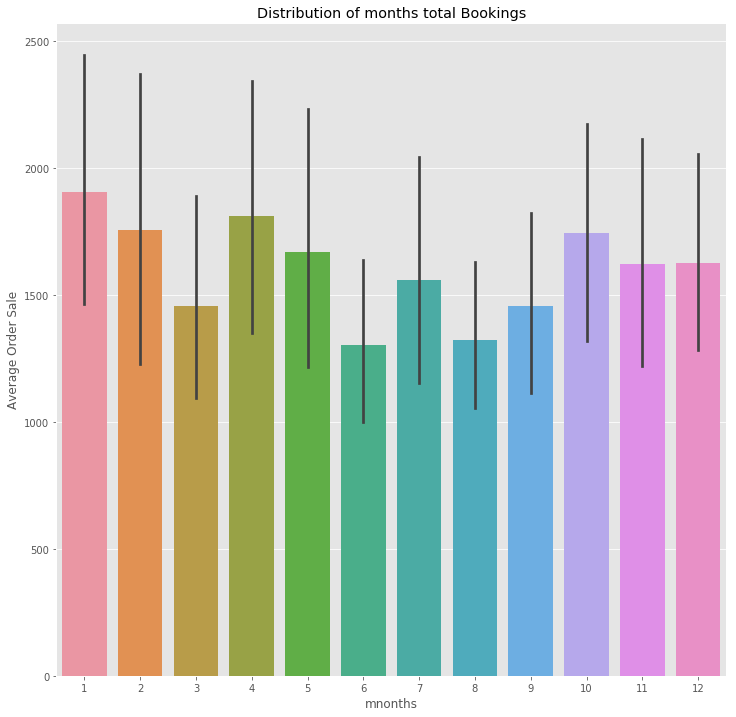

In [97]:
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='month', data=df_seasons)
plt.title('Distribution of months total Bookings')
plt.xlabel('mnonths')
plt.ylabel('Average Order Sale');

Text(0, 0.5, 'Density')

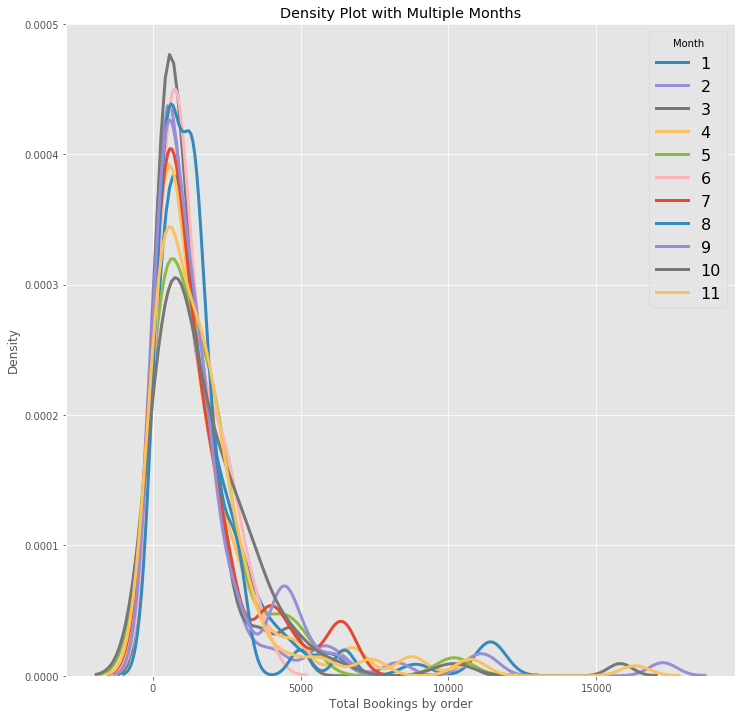

In [99]:
# Do overlapping distribtion Plot on monthly data
plt.figure(figsize=(12,12))
for i in range(0,12):
    # Subset to the airline
    subset = df_seasons[df_seasons['month'] == i]
    
    # Draw the density plot
    sns.distplot(subset['total_bookings'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = i)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Month')
plt.title('Density Plot with Multiple Months')
plt.xlabel('Total Bookings by order')
plt.ylabel('Density')

Looking at the first visuzliztion, it seems like the summer months have lower on average sales. We can use an ANOVA Test to see if there is any significant effet. We can define our hypothesis as:

**Null Hypothesis**: Month of order date has no significant effect on the average order size

**Alternate Hypothesis**: Month of order date has a significant effect on the average order size at a p level of .05


In [100]:
# ANOVA Test
results = ols('total_bookings ~ C(month)', data=df_seasons).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6015
Date:                Mon, 22 Jul 2019   Prob (F-statistic):              0.829
Time:                        14:25:07   Log-Likelihood:                -7478.7
No. Observations:                 830   AIC:                         1.498e+04
Df Residuals:                     818   BIC:                         1.504e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1903.9491    212.763      8.949      0.000    1486.322    2321.576
C(month)[T.2]   -147.6943    305.391     -0.484      0.629    -747.136     451.748
C(month)[T.3]   -449.5282    289.731     -1.552      0.121   -1018.232     119.176
C(month)[T.4]    -91.2829    288.457     -0.316      0.752    -657.486     474.920
C(month)[T.5]   -236.0717    363.137     -0.650      0.516    -948.862     476.719
C(month)[T.6]   -601.0158    421.966     -1.424      0.155   -1429.279     227.248
C(month)[T.7]   -346.5485    343.071     -1.010      0.313   -1019.951     326.854
C(month)[T.8]   -583.4131    337.567     -1.728      0.084   -1246.012      79.186
C(month)[T.9]   -447.7988    334.158     -1.340      0.181   -1103.708     208.110
C(month)[T.10]  -161.2600    327.891     -0.492      0.623    -804.866     482.346
C(month)[T.11]  -283.3159    335.838     -0.844      0.399    -942.522     375.890
C(month)[T.12]  -278.2572    309.344     -0.900      0.369    -885.459     328.944
==============================================================================
Omnibus:                      636.870   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10981.068
Skew:                           3.412   Prob(JB):                         0.00
Kurtosis:                      19.461   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the ANOVA, there is no significant effect. Since sales are usually quarterly based, let's add a new column to the dataframe that classifies the order date by the quarter in which it was placed to see if there is any effect of the quarter on Average order size

In [102]:
# Add Quarters to see if average order size changes over quarters
quarters = []
for i in df_seasons.month:
    if i in (1,2,3):
        q =1
    if i in (4, 5, 6):
        q = 2
    if i in (7,8,9):
        q = 3
    if i in (10, 11, 12):
        q = 4
    quarters.append(q)
df_seasons['quarter'] = quarters

# No need to check value counts since every month was above 30

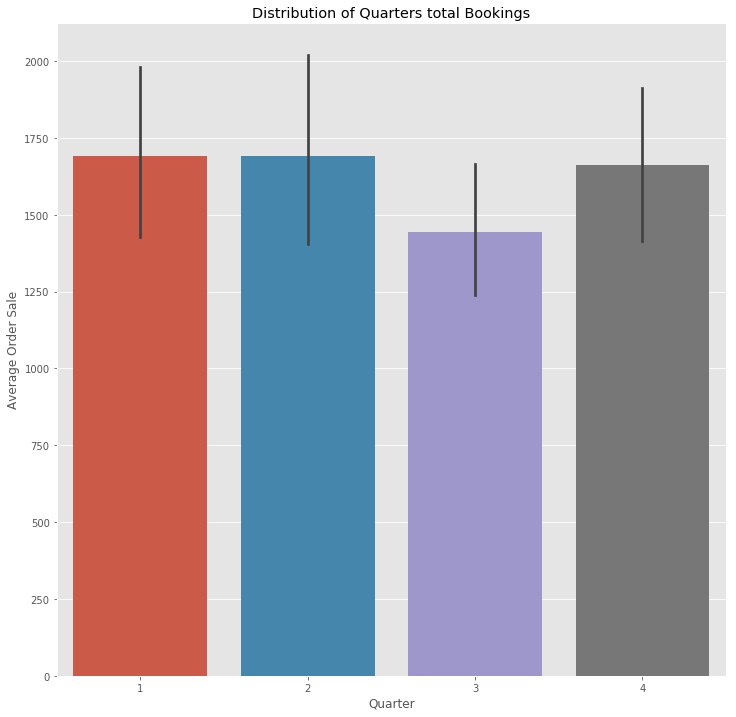

In [103]:
# Visualize the Data
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='quarter', data=df_seasons)
plt.title('Distribution of Quarters total Bookings')
plt.xlabel('Quarter')
plt.ylabel('Average Order Sale');

It looks like Q3 had a lower than average sales price. Let's see if this is significant by running another ANOVA, since the error bars point to it being within range of insignificance.  

**Null Hypothesis**: Changes in quarter has no significant effect on the average order price

**Alternate Hypothesis**: Changes in quarter has a significant effect on the average order price

In [104]:
# ANOVA test
results = ols('total_bookings ~ C(quarter)', data=df_seasons).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6661
Date:                Mon, 22 Jul 2019   Prob (F-statistic):              0.573
Time:                        14:27:36   Log-Likelihood:                -7481.1
No. Observations:                 830   AIC:                         1.497e+04
Df Residuals:                     826   BIC:                         1.499e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1690.2264    120.330     14.047      0.000    1454.038    1926.415
C(quarter)[T.2]     1.1566    190.783      0.006      0.995    -373.321     375.634
C(quarter)[T.3]  -247.3527    193.422     -1.279      0.201    -627.008     132.303
C(quarter)[T.4]   -28.9436    184.715     -0.157      0.876    -391.510     333.622
==============================================================================
Omnibus:                      639.712   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11026.036
Skew:                           3.435   Prob(JB):                         0.00
Kurtosis:                      19.481   Cond. No.                         4.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With a p value at .5, we do not reject the null hypothesis. Although there is an obervational difference between the means, there is no significant effect of quarter on average sales order. Lastly, let's go one more level and see if there is any effect of the day of the week on sales.

In [105]:
# Do certain days of the week affect sales?
dow = []
for i in df_seasons.datetime:
    w = i.weekday()
    dow.append(w)
df_seasons['dow'] = dow

In [106]:
df_seasons.dow.value_counts()

2    168
0    168
6    165
1    165
3    164
Name: dow, dtype: int64

Datetime documentation shows that values of 5 & 6 are meant for Saturday and Sunday. Interestingly, we are missing values at 4 & 5 instead. Since this is a sample database, I'm assuming that the missing values (4,5) refer to Saturday and Sunday, and that sales are only placed during the week, making it okay to not have these values. Let's visualize the data to see if we notice any patterns. 

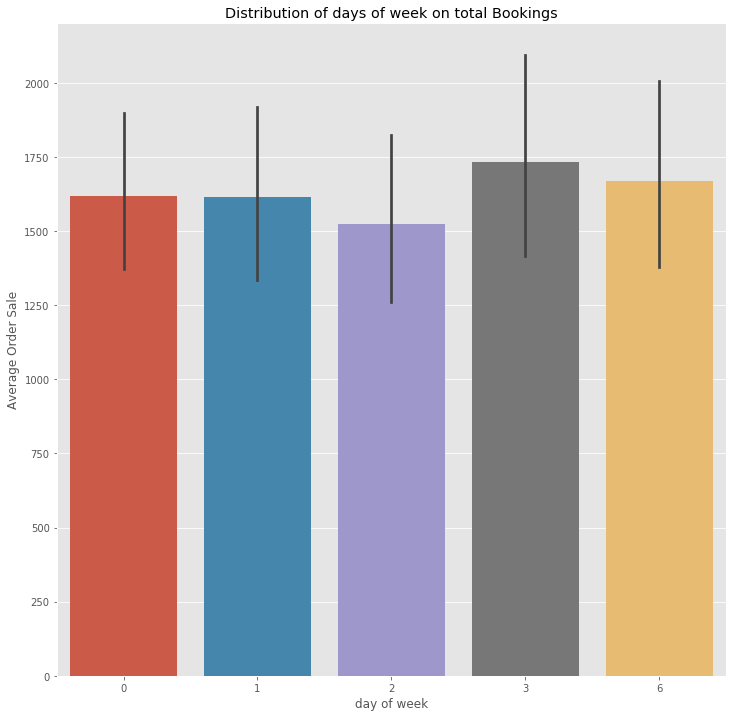

In [83]:
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='dow', data=df_seasons)
plt.title('Distribution of days of week on total Bookings')
plt.xlabel('day of week')
plt.ylabel('Average Order Sale');

Not super confident in there being any real trend here. But let's run an ANOVA to be sure with the following hypotheses:

**Null Hypothesis**: There is no significant difference between the days of the week and the average order size

**Alternative Hypothesis**: the day of the week has a significant effect on the average order size

In [107]:
#ANOVA Test
results = ols('total_bookings ~ C(dow)', data=df_seasons).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2472
Date:                Mon, 22 Jul 2019   Prob (F-statistic):              0.911
Time:                        14:30:17   Log-Likelihood:                -7481.6
No. Observations:                 830   AIC:                         1.497e+04
Df Residuals:                     825   BIC:                         1.500e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1619.7218    153.859     10.527      0.000    1317.721    1921.723
C(dow)[T.1]    -4.2581    218.576     -0.019      0.984    -433.289     424.773
C(dow)[T.2]   -95.0596    217.589     -0.437      0.662    -522.153     332.034
C(dow)[T.3]   114.3857    218.912      0.523      0.601    -315.304     544.076
C(dow)[T.6]    48.5018    218.576      0.222      0.824    -380.529     477.533
==============================================================================
Omnibus:                      642.575   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11171.031
Skew:                           3.455   Prob(JB):                         0.00
Kurtosis:                      19.592   Cond. No.                         5.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the p value of the F statistic is so high, we do not reject the null and conclude that day of the week has no significant effect on the average order size. We have found no significant trends at the montly, quarterly, or weekly level on the average order size